# Unscented Kalman FIlter for object tracking

In this project, two different datasets (including sensor measurements of a lidar and a radar sensor and the ground truth data) are used to test the performance of an Unscented Kalman Filter (UKF). These datasets are included in the "sample-laser-radar-measurement-data-1.txt" and "sample-laser-radar-measurement-data-2.txt" files. For the sake of brevity, I refer to these files as dataset 1 and dataset 2 respectively. The newly added dataset "obj_pose-laser-radar-synthetic-input.txt" (refered to as dataset 3) is also analyzed and discussed albeit in fewer details compared to datasets 1 and 2.

Dataset 1: The percentage of the acceptable NIS values: 91.18


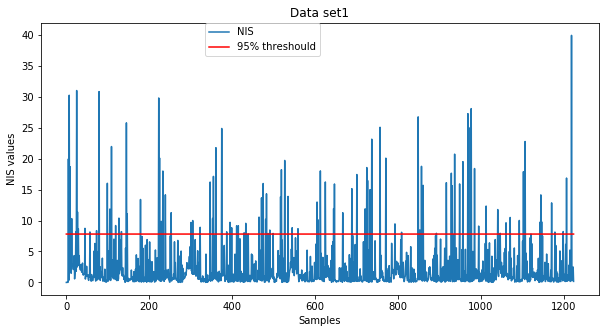

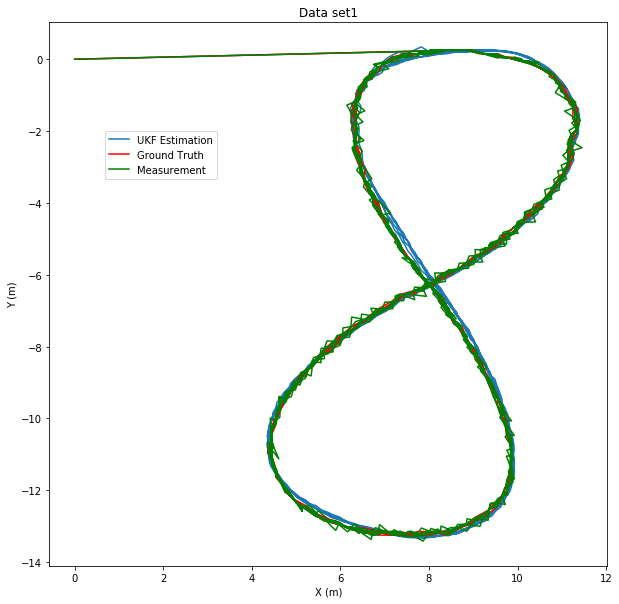

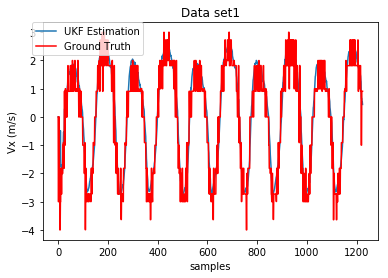

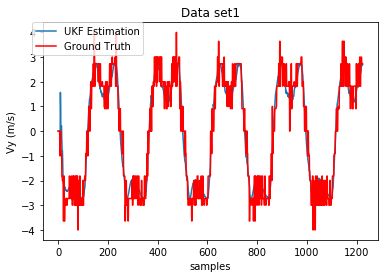

Dataset 2: The percentage of the acceptable NIS values: 99.50


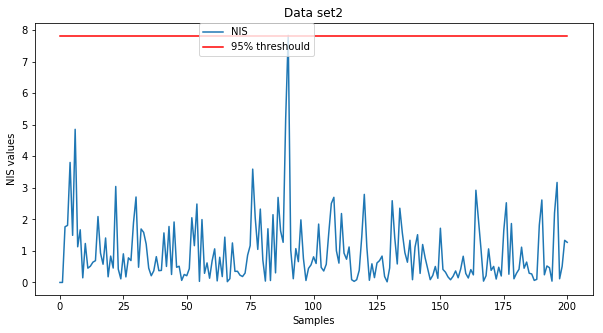

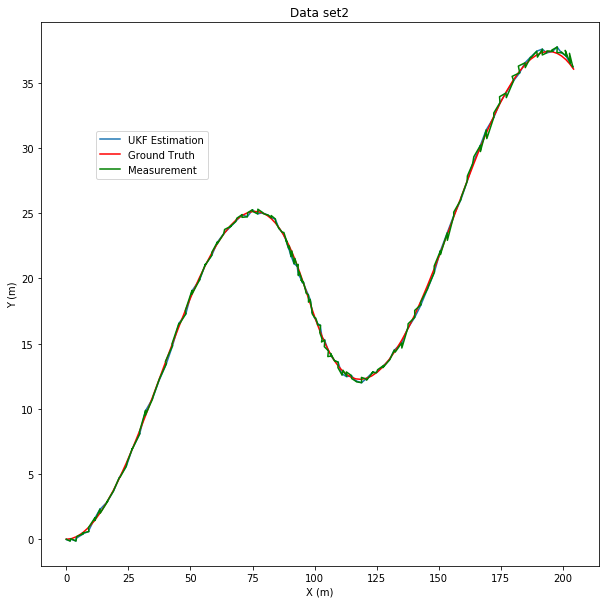

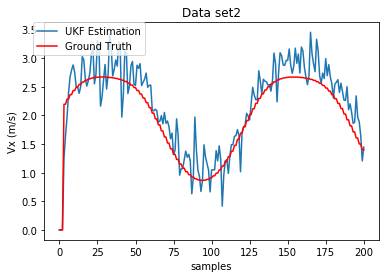

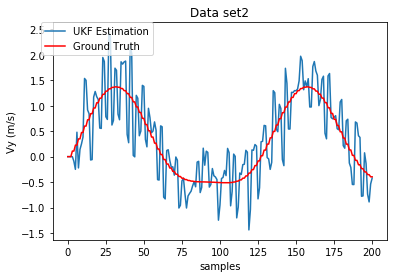

Dataset 3: The percentage of the acceptable NIS values: 97.41


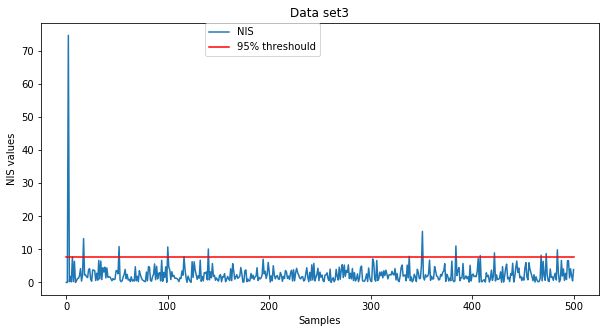

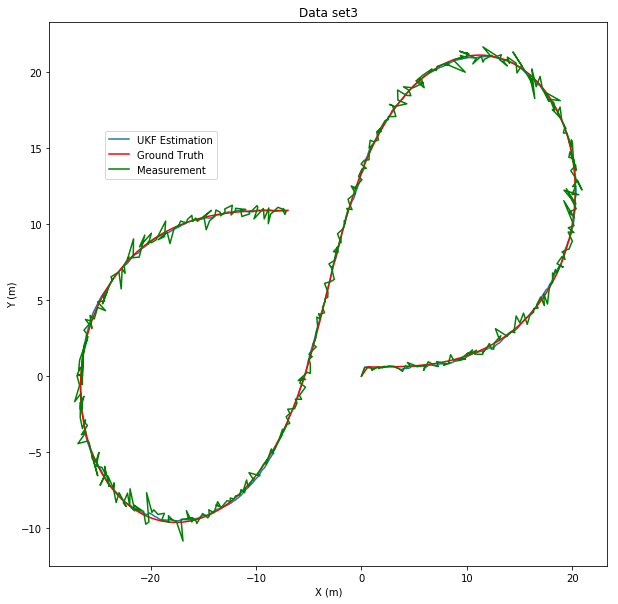

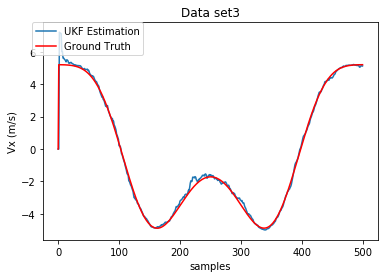

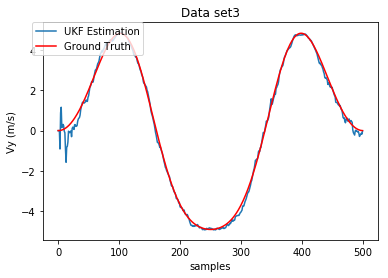

In [1]:
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import math
from sklearn.metrics import mean_squared_error


# define some arrays to store rmse values for project 2 and load the values from project 1 (EKF)
rmse_ukf = np.zeros((3,4))
rmse_ekf = np.array(( (0.065,0.061,0.533,0.544), (0.185,0.190,0.477,0.805) ))
# new upper boulds for RMSEs in Project 2
rmse_bounds = np.array(((0.09, 0.09, 0.65, 0.65), (0.20, 0.20, 0.55, 0.55), (.09, .10, .40, .30)))

# scan through the saved results and plot the NIS, positions and velocities for the anlysis of results
for j in range(1,4):
    result_file = open("data/output-"+str(j)+".txt", "r")
    lines = result_file.readlines()
    total_samples = len(lines)
    nis = np.zeros(total_samples)
    px_est = np.zeros(total_samples)
    py_est = np.zeros(total_samples)
    vx_est = np.zeros(total_samples)
    vy_est = np.zeros(total_samples)
    px_act = np.zeros(total_samples)
    py_act = np.zeros(total_samples)
    vx_act = np.zeros(total_samples)
    vy_act = np.zeros(total_samples)
    px_sen = np.zeros(total_samples)
    py_sen = np.zeros(total_samples)
    # the 95% threhold for kai squared distribution (used for evaluating the NIS values)
    acc_const = 7.815
    quality_line = acc_const*np.ones(total_samples)
    i = 0

    for line in lines:
        values = line.split("\t")
        if i != 0:
            px_est[i] = values[0]
            py_est[i] = values[1]
            vx_est[i] = float(values[2])*math.cos(float(values[3]))
            vy_est[i] = float(values[2])*math.sin(float(values[3]))
            px_sen[i] = values[5]
            py_sen[i] = values[6]
            px_act[i] = values[7]
            py_act[i] = values[8]
            vx_act[i] = values[9]
            vy_act[i] = values[10]
            nis[i] = values[11]
        i = i + 1
    result_file.close()
    rmse_px =  np.sqrt(mean_squared_error(px_est,px_act))
    rmse_py =  np.sqrt(mean_squared_error(py_est,py_act))
    rmse_vx =  np.sqrt(mean_squared_error(vx_est,vx_act))
    rmse_vy =  np.sqrt(mean_squared_error(vy_est,vy_act))
    
    rmse_ukf[j-1,:] = (rmse_px,rmse_py,rmse_vx,rmse_vy)
    
    unacceptable = np.zeros(total_samples)
    unacceptable[nis>acc_const] = 1

    unacceptable_precentage = sum(unacceptable)/total_samples*100
    print("Dataset "+str(j)+": The percentage of the acceptable NIS values: {:.2f}".format(100-unacceptable_precentage))

    x = range(0,total_samples)
    fig1 = pl.figure(figsize=(10,5))
    plot1 = pl.plot(x,nis, label='NIS')
    plot2 = pl.plot(x,quality_line,'r', label='95% threshould')

    pl.title('Data set'+str(j))
    pl.xlabel('Samples')
    pl.ylabel('NIS values')
    plt.legend(bbox_to_anchor=(0.5, 1), loc=1, borderaxespad=0.)
    pl.show()
    #print(px_act)
    fig2 = pl.figure(figsize=(10,10))
    plot1 = pl.plot(px_est,py_est,label='UKF Estimation')
    plot2 = pl.plot(px_act,py_act,'r',label='Ground Truth')
    plot3 = pl.plot(px_sen,py_sen,'g',label='Measurement')
    plt.legend(bbox_to_anchor=(0.3, 0.8), loc=1, borderaxespad=0.)
    pl.title('Data set'+str(j))
    pl.xlabel('X (m)')
    pl.ylabel('Y (m)')
    pl.show()
    
    fig3 = pl.figure(3)
    plot1 = pl.plot(x,vx_est,label='UKF Estimation')
    plot2 = pl.plot(x,vx_act,'r',label='Ground Truth')
    plt.legend(bbox_to_anchor=(0.3, 1), loc=1, borderaxespad=0.)
    pl.title('Data set'+str(j))
    pl.xlabel('samples')
    pl.ylabel('Vx (m/s)')
    pl.show()
    
    fig4 = pl.figure(4)
    plot1 = pl.plot(x,vy_est,label='UKF Estimation')
    plot2 = pl.plot(x,vy_act,'r',label='Ground Truth')
    plt.legend(bbox_to_anchor=(0.3, 1), loc=1, borderaxespad=0.)

    pl.title('Data set'+str(j))
    pl.xlabel('samples')
    pl.ylabel('Vy (m/s)')
    pl.show()

    


# Discussion

From the results of datasets 1 and 2, it can be seen that the true (ground truth) velocities in dataset 1 are much noisier and hence a low rmse for vx and vy requires higher values of std_a and std_yawdd. This is in contrast to the dataset 2 which has smoother true (ground truth) velocity curves. In this case, lower values of acceleration noise std_a and std_yawdd reduce the rmse for vx and vy. Therefore, making a balance between the results of two datasets becomes challenging specially when keeping both NIS values below 7.815 for 95% samples. The dataset 3 is more tractable since the ground turth data follows a curves that are even smoother than dataset 2. 

In the following, the results of UKF and EKF for datasets 1 and 2 are compared along with the design criteria for project 2. In project 1, the rmse boulds for dataset 2 were [0.20, 0.20, .50, .85] which are now more restricted in project 2 i.e. [0.20, 0.20, 0.55, 0.55]. However, the rmse boulds for dataset 1 in project 1 were  [0.08, 0.08, 0.60, 0.60] which are now less restricted in project 2 i.e. [0.09, 0.09, 0.65, 0.65]. As it can be seen the following bar plots, for more or less the same range of RMSE for dataset 1 using UKF and EKF, the RMSE values for vx and vy are considerablly lower with UKF in contrast to the EKF. This might be the results of using sigmapoints to estimate nonlinear distributions which is not the case in EKF.

Finally, a bar plot for dataset 3 is shown to compare the RMSE values against the design criteria for this dataset. Since this dataset was later added to the project, slightly different values for the noise parameters are used to minimize the RMSEs as much as possible (please refer to the corresponding part of the ukf.cpp code for the values). However, datasets 1 and 2 share a common set of noise parameters. 



Comparison of the UKF and EKF results for datasets 1 and 2:
The values of RMSE for UKF for dataset 1: [ 0.07206774  0.0800669   0.59031461  0.57390038]


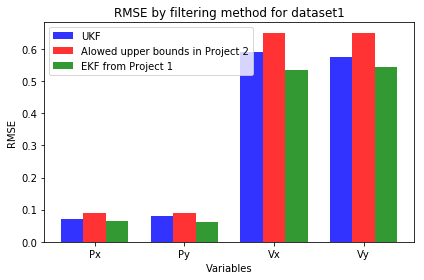

The values of RMSE for UKF for dataset 2: [ 0.18806783  0.18822473  0.33266384  0.48672939]


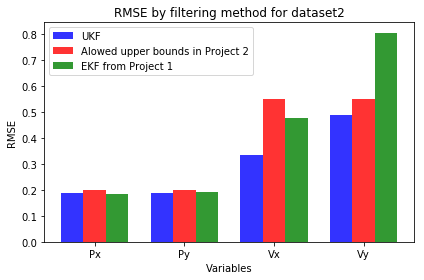

The values of RMSE for UKF for dataset 3: [ 0.06032814  0.08595325  0.32927661  0.21280576]


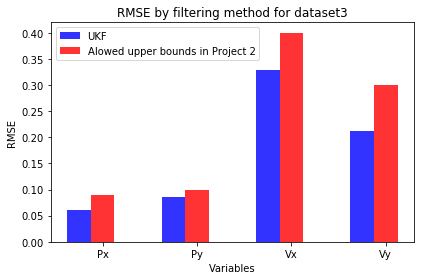

In [2]:
print('Comparison of the UKF and EKF results for datasets 1 and 2:')


n_groups = 4

 
for j in range(0,3):
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.25
    opacity = 0.8
    print('The values of RMSE for UKF for dataset '+str(j+1)+':',rmse_ukf[j,:])
    rects1 = plt.bar(index, rmse_ukf[j,:], bar_width,
                     alpha=opacity,
                     color='b',
                     label='UKF')

    rects2 = plt.bar(index + bar_width, rmse_bounds[j,:], bar_width,
                     alpha=opacity,
                     color='r',
                     label='Alowed upper bounds in Project 2')
    if j in range(0,2):
        rects3 = plt.bar(index + 2*bar_width, rmse_ekf[j,:], bar_width,
                         alpha=opacity,
                         color='g',
                         label='EKF from Project 1')

    plt.xlabel('Variables')
    plt.ylabel('RMSE')
    plt.title('RMSE by filtering method for dataset'+str(j+1))
    plt.xticks(index + bar_width, ('Px', 'Py', 'Vx', 'Vy'))
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    